In [47]:
# Note: assuming python 3.5

from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split
from gavin_utils.prep_data import MyDataSet
from gavin_utils.clean_text import FeatureGeneration

from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer
)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = DataSet(name='train', path='fnc-1')

headlines = [item['Headline'] for item in train_data.stances]

print("Total number of headlines:", len(headlines))
print("Unique headlines:", len(set(headlines)))

print("Total max possible stances:", len(set(headlines)) ** 2)

Reading dataset
Total stances: 49972
Total bodies: 1683
Total number of headlines: 49972
Unique headlines: 1648
Total max possible stances: 2715904


It isn't necessarily clear from the documentation, but they seem to have re-used headlines to increase the size of the data set. The actual headline for one article is "used" on additional articles and we still have labelled stances for these observations although most of them are probaby unrelated.

# Reformat data

I'm going to reformat the data into either pandas dataframes or numpy arrays. Both are easier to work with and more efficient than python standard lists/dicts.

In [3]:
all_data = MyDataSet()

Reading dataset


In [4]:
train = all_data.train

train.head()

,Headline,Stance,body
Body ID,,,
0,"Soldier shot, Parliament locked down after gun...",unrelated,A small meteorite crashed into a wooded area i...
0,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,A small meteorite crashed into a wooded area i...
0,Luke Somers 'killed in failed rescue attempt i...,unrelated,A small meteorite crashed into a wooded area i...
0,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,A small meteorite crashed into a wooded area i...
0,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,A small meteorite crashed into a wooded area i...


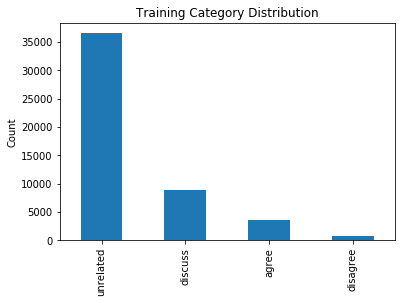

In [5]:
train['Stance'].value_counts().plot(kind='bar');
plt.ylabel('Count');
plt.title('Training Category Distribution');

As suspected, there's a very large representation of the 'unrelated' stance. We should be careful during classification that we take this into account in designing an appropriate scoring metric.

In [5]:
train[train['Stance'] == 'agree'].head()

,Headline,Stance,body
Body ID,,,
0,Small Meteorite Strikes in Nicaragua's Capital...,agree,A small meteorite crashed into a wooded area i...
8,What was fake on the Internet this week: Obama...,agree,There is so much fake stuff on the Internet in...
9,"Meteorite makes big crater in Nicaragua, gover...",agree,"(CNN) -- A meteorite crashed down in Managua, ..."
9,Small Meteorite Strikes in Nicaragua's Capital...,agree,"(CNN) -- A meteorite crashed down in Managua, ..."
13,A soldier has been shot at Canada’s war memori...,agree,A SOLDIER has been shot at Canada’s National W...


# Cleaning text

* **Remove uppercase and non alphanumeric characters** to eventually reduce the overall size of the feature space. The benefits of reducing dimensionality is likely to outweigh the cost of whatever difference there may be between upper and lower case or the meaning communicated through punctuation.
* **Use stemming or lemmatization**.
* **Remove stopwords** that don't really contribute to meaning.

# Featurization

We need to go from a bag of words (really a list of words) for each data point to a vector that represents the bag of words. There are several ways to do this, and I'm going to try all of them.

* **Count vectorizer**: Create a vector of the same length as the number of unique words and count the occurence in each document of those words.
* **Text frequency-inverse document frequency** (Tf-Idf) is the same as a count vectorizer except one divides by the number of documents in which this word occured. This weights less common words as more important than more common words.
* **Word/Doc2Vec** embeddings represent words or documents as vectors in a high dimensional space. They are fairly complicated models, but many open source models have already been trained on huge corpuses of english text.

In [52]:
feature_gen = FeatureGeneration(train, name='train')

data reloaded


In [53]:
feature_gen.add_word_intersection()
feature_gen.add_count_features()
feature_gen.add_tfidf_features()

In [54]:
train = feature_gen.df

In [55]:
train.head()

,Headline,Stance,body,intersection,intersection_pct,cosine_similarity_count,headline_tfidf_vec,body_tfidf_vec,cosine_similarity_tfidf
Body ID,,,,,,,,,
0,"[soldier, shot, parliament, locked, gunfire, e...",unrelated,"[small, meteorite, crashed, wooded, area, nica...",{},0.000000,0.000000,"(0, 99425)\t0.260701909909\n (0, 99388)\t0....","(0, 102019)\t0.0398955453155\n (0, 102018)\...",0.000000
0,"[tourist, dubbed, spider, man, spider, burrow,...",unrelated,"[small, meteorite, crashed, wooded, area, nica...",{},0.000000,0.000000,"(0, 99425)\t0.260701909909\n (0, 99388)\t0....","(0, 102019)\t0.0398955453155\n (0, 102018)\...",0.000000
0,"[luke, somers, killed, failed, rescue, attempt...",unrelated,"[small, meteorite, crashed, wooded, area, nica...",{},0.000000,0.000000,"(0, 99425)\t0.260701909909\n (0, 99388)\t0....","(0, 102019)\t0.0398955453155\n (0, 102018)\...",0.000000
0,"[breaking, soldier, shot, war, memorial, ottawa]",unrelated,"[small, meteorite, crashed, wooded, area, nica...",{},0.000000,0.000000,"(0, 99425)\t0.260701909909\n (0, 99388)\t0....","(0, 102019)\t0.0398955453155\n (0, 102018)\...",0.000000
0,"[giant, 8ft, 9in, catfish, weighing, 19, stone...",unrelated,"[small, meteorite, crashed, wooded, area, nica...",{thought},0.006897,0.006808,"(0, 99425)\t0.260701909909\n (0, 99388)\t0....","(0, 102019)\t0.0398955453155\n (0, 102018)\...",0.002476


In [56]:
train['body_tfidf_vec'].iloc[0]

<49972x103898 sparse matrix of type '<class 'numpy.float64'>'
	with 16011957 stored elements in Compressed Sparse Row format>